In [1]:
SEED = 42

Google Drive 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install dependencies

In [3]:
!pip install livelossplot -q

# Imports

In [4]:
import tensorflow as tf
from pathlib import Path
from os.path import abspath
import pandas as pd
import os
from livelossplot import PlotLossesKeras

available_gpus = tf.config.list_physical_devices('GPU')
print(f"Number of available GPUs: {len(available_gpus)}")

try:
    tf.config.experimental.set_memory_growth(available_gpus[0], True)
except:
    pass

Number of available GPUs: 1


# Paths

In [5]:
SRC_DIR = Path('/content/drive/MyDrive/TAI/III/nlp/')
DATA_DIR = SRC_DIR / "data"
LOG_DIR = SRC_DIR / 'logs'
BEST_MODEL_DIR = LOG_DIR / "checkpoints"
TENSOR_BOARD_DIR = LOG_DIR / "tensor_board"

# Dataset

## Load dataset

In [6]:
dataset_df = pd.read_csv(os.path.join(DATA_DIR, "dataset.csv"))

## Dataset info

In [7]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105354 entries, 0 to 105353
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               105354 non-null  int64 
 1   followers_count  105354 non-null  int64 
 2   verified         105354 non-null  bool  
 3   reactions_count  105354 non-null  int64 
 4   retweet_count    105354 non-null  int64 
 5   text             105354 non-null  object
 6   source           105354 non-null  object
 7   description      89892 non-null   object
 8   replies_count    105354 non-null  int64 
 9   fake             105354 non-null  bool  
dtypes: bool(2), int64(5), object(3)
memory usage: 6.6+ MB


In [8]:
dataset_df.head()

,id,followers_count,verified,reactions_count,retweet_count,text,source,description,replies_count,fake
0,498254340310966273,1080,False,53,286,Michael Brown is the 17 yr old boy who was sho...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Sr.Lecturer @IEDP_PennGSE | GlobalDev + Migrat...,0,True
1,498260814487642112,1639,False,1,1,@AmeenaGK @jaythenerdkid And how long before a...,"<a href=""http://twitter.com/download/iphone"" r...",#TeamRocketRaccoon #TeamEternia #TeamEtheria #...,0,True
2,498261272174284801,6612,False,0,0,@d_m_elms @AmeenaGK they'll drag his entire hi...,"<a href=""http://twitter.com/download/android"" ...",muslim cis queer neuroatypical intersectional ...,0,True
3,498261302733967361,1070,False,1,2,@d_m_elms @jaythenerdkid or traces back some b...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Sr.Lecturer @IEDP_PennGSE | GlobalDev + Migrat...,0,True
4,498261642099326976,1639,False,5,9,@AmeenaGK @jaythenerdkid CHILD KILLED TO PROTE...,"<a href=""http://twitter.com/download/iphone"" r...",#TeamRocketRaccoon #TeamEternia #TeamEtheria #...,0,True


In [9]:
dataset_df['fake'].value_counts()

False    72229
True     33125
Name: fake, dtype: int64

Duplicates and NaNs

In [10]:
dataset_df.duplicated().sum()

0

In [11]:
dataset_df.isnull().sum()

id                     0
followers_count        0
verified               0
reactions_count        0
retweet_count          0
text                   0
source                 0
description        15462
replies_count          0
fake                   0
dtype: int64

## Clean data

### Drop NaNs

In [12]:
dataset_df = df = dataset_df.fillna('')

## Map type to int

In [13]:
mapping = {False: 0, True: 1}
dataset_df['class'] = dataset_df['fake']
dataset_df = dataset_df.replace({'class': mapping})

## Merge title and text

In [14]:
dataset_df['text_combined'] = dataset_df['text'] + ' ' + dataset_df['description']

In [15]:
dataset_df.head()

,id,followers_count,verified,reactions_count,retweet_count,text,source,description,replies_count,fake,class,text_combined
0,498254340310966273,1080,False,53,286,Michael Brown is the 17 yr old boy who was sho...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Sr.Lecturer @IEDP_PennGSE | GlobalDev + Migrat...,0,True,1,Michael Brown is the 17 yr old boy who was sho...
1,498260814487642112,1639,False,1,1,@AmeenaGK @jaythenerdkid And how long before a...,"<a href=""http://twitter.com/download/iphone"" r...",#TeamRocketRaccoon #TeamEternia #TeamEtheria #...,0,True,1,@AmeenaGK @jaythenerdkid And how long before a...
2,498261272174284801,6612,False,0,0,@d_m_elms @AmeenaGK they'll drag his entire hi...,"<a href=""http://twitter.com/download/android"" ...",muslim cis queer neuroatypical intersectional ...,0,True,1,@d_m_elms @AmeenaGK they'll drag his entire hi...
3,498261302733967361,1070,False,1,2,@d_m_elms @jaythenerdkid or traces back some b...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Sr.Lecturer @IEDP_PennGSE | GlobalDev + Migrat...,0,True,1,@d_m_elms @jaythenerdkid or traces back some b...
4,498261642099326976,1639,False,5,9,@AmeenaGK @jaythenerdkid CHILD KILLED TO PROTE...,"<a href=""http://twitter.com/download/iphone"" r...",#TeamRocketRaccoon #TeamEternia #TeamEtheria #...,0,True,1,@AmeenaGK @jaythenerdkid CHILD KILLED TO PROTE...


## Split dataset to train, val and test

Function

In [16]:
from sklearn.model_selection import train_test_split

# separate data into data and labels 
features = dataset_df['text_combined'].tolist()
targets = dataset_df['class'].tolist()

# splitting data into training, testing, and validation sets 
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=SEED)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=SEED)


### Convert X, y to tensors

In [17]:
X_train =  tf.constant(X_train, dtype=tf.string)
X_test =  tf.constant(X_test, dtype=tf.string)
X_val =  tf.constant(X_val, dtype=tf.string)

In [18]:
y_train = tf.constant(y_train, dtype='float32')
y_test = tf.constant(y_test, dtype='float32')
y_val = tf.constant(y_val, dtype='float32')

# Model

## Parameters

In [70]:
BATCH_SIZE = 64
EPOCHS = 100
VOCABULARY_SIZE = 100000
MAX_SEQUENCE_LEN = 300
EMBEDDING_DIM = 75

## Vectorization layer

In [71]:
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize='lower',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LEN,
)
vectorize_layer.adapt(X_train, batch_size=BATCH_SIZE)

## Model architecture

In [72]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim=VOCABULARY_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_4 (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 embedding_7 (Embedding)     (None, 300, 75)           7500000   
                                                                 
 dropout (Dropout)           (None, 300, 75)           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 256)              208896    
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 7,709,153
Trainable params: 7,709,153
No

## Metrics

In [73]:
METRICS = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc'),
    ]

## Compile

In [74]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics= METRICS 
)

## Callbacks

In [75]:
BEST_MODEL_FILE = BEST_MODEL_DIR / "lstm005_best"

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=1, min_delta=0.001)
save_best = tf.keras.callbacks.ModelCheckpoint(filepath=BEST_MODEL_FILE, monitor='val_loss', save_best_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(filename=LOG_DIR / "history5.csv")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=str(TENSOR_BOARD_DIR.resolve()))

## Train

In [76]:
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[save_best, early_stop, csv_logger],
    )

Epoch 1/100
1317/1317 [==============================] - ETA: 0s - loss: 0.3348 - accuracy: 0.8475 - recall: 0.6873 - precision: 0.7992 - auc: 0.9166

1317/1317 [==============================] - 100s 73ms/step - loss: 0.3348 - accuracy: 0.8475 - recall: 0.6873 - precision: 0.7992 - auc: 0.9166 - val_loss: 0.2496 - val_accuracy: 0.8897 - val_recall: 0.8042 - val_precision: 0.8415 - val_auc: 0.9555
Epoch 2/100
1317/1317 [==============================] - ETA: 0s - loss: 0.1644 - accuracy: 0.9300 - recall: 0.8897 - precision: 0.8876 - auc: 0.9807

1317/1317 [==============================] - 62s 47ms/step - loss: 0.1644 - accuracy: 0.9300 - recall: 0.8897 - precision: 0.8876 - auc: 0.9807 - val_loss: 0.2406 - val_accuracy: 0.8902 - val_recall: 0.8019 - val_precision: 0.8445 - val_auc: 0.9588
Epoch 3/100
1317/1317 [==============================] - 46s 35ms/step - loss: 0.1009 - accuracy: 0.9582 - recall: 0.9355 - precision: 0.9319 - auc: 0.9926 - val_loss: 0.2709 - val_accuracy: 0.8899 - val_recall: 0.7875 - val_precision: 0.8544 - val_auc: 0.9558
Epoch 4/100
1317/1317 [==============================] - 44s 33ms/step - loss: 0.0641 - accuracy: 0.9738 - recall: 0.9597 - precision: 0.9570 - auc: 0.9968 - val_loss: 0.3574 - val_accuracy: 0.8846 - val_recall: 0.8001 - val_precision: 0.8303 - val_auc: 0.9426
Epoch 5/100
1317/1317 [==============================] - 43s 33ms/step - loss: 0.0419 - accuracy: 0.9828 - recall: 0.9724 - precision: 0.9729 - auc: 0.9987 - val_loss: 0.4280 - val_accuracy: 0.8726 - val_recall: 0.8395 - val_prec

## Plot metrics history

In [77]:
import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history, metric_names):
  for n, metric in enumerate(metric_names):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()



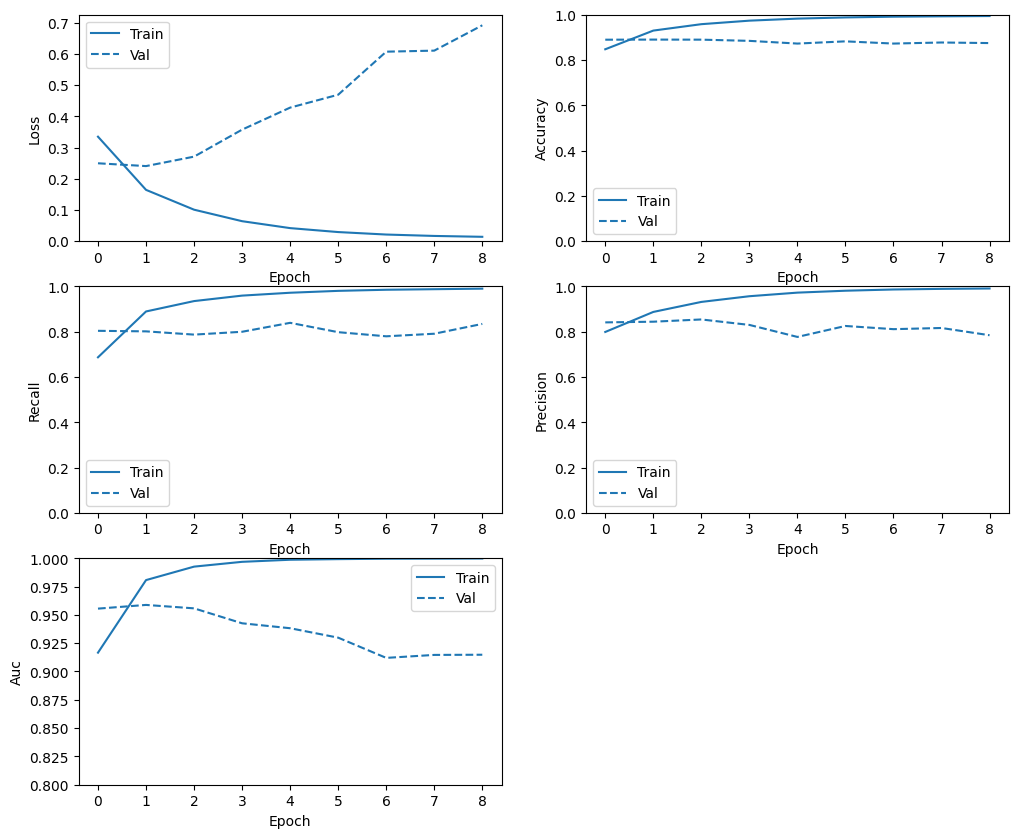

In [78]:
metrics = ["loss", 'accuracy', 'recall', 'precision', 'auc']
plt.figure(figsize=(12,10))
plot_metrics(history, metrics)

# Evaluation

In [79]:
model.evaluate(X_test, y_test)

330/330 [==============================] - 4s 12ms/step - loss: 0.7103 - accuracy: 0.8732 - recall: 0.8409 - precision: 0.7733 - auc: 0.9142


[0.7102828621864319,
 0.8731846213340759,
 0.8409228920936584,
 0.7733110189437866,
 0.9141771197319031]